In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

### 特徴選択から再度実施
### Scikit-learnによる分類
* 実際のデータで，説明変数が多次元の場合のモデルを構築

説明変数として考えられるもの
* goal : 目標金額
* deadline :　納期
* launched : 開始日
* country : PJ開催国
* currency : 通貨の単位
* deadline_days : 納期への近さ
* goal_per_days : 1日あたりの目標金額
* category_xxx : PJの小分類がxxxかどうか
* name_length : PJ名の長さ
* name_xxx : PJのタイトルにxxxが含まれているか

In [2]:
#CSVファイル読み込み
df = pd.read_csv("../1_data/ks-projects-201801.csv")
df.index.name="id"

In [3]:
#欠損値がある列を確認
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [4]:
#欠測値がある列を落とす
#stateが「live」のデータを落としていることを明示するためにあえて記載
df = df[df['state'] != 'live']
df = df[~df['name'].isnull()]
df = df[~df['usd pledged'].isnull()]

In [5]:
df['state'].loc[df['state'] == 'successful'] = 1
df['state'].loc[df['state'] != 1] = 0

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#nameの長さを取得
df['name_length'] = df['name'].apply(lambda x: len(str(x).replace(' ', ''))).fillna(0)

In [7]:
#deadline,launchedを日付に変換するための関数
def period_to_date(x_date, format_date):
    x_date_format = datetime.datetime.strptime(x_date, format_date)
    return x_date_format

In [8]:
#deadline と　launched からプロジェクト納期への近さ(日数)を計算
df['deadline_period'] = df['deadline'].apply(lambda x : period_to_date(x, '%Y-%m-%d')) \
- df['launched'].apply(lambda x : period_to_date(x, '%Y-%m-%d %H:%M:%S'))
df['deadline_days'] = df['deadline_period'].apply(lambda x : x.days)

#goal に対して納期への日数1日あたりいくら必要かを計算
df['goal_per_days'] = df['goal'] / df['deadline_days']
df['goal_per_days'] = df['goal_per_days'].fillna(0)
df['goal_per_days'] [df['goal_per_days'] == np.inf]= 0

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
#pairplot用の変数を揃える
#ここでは更に、goal_per_days(1日あたりの目標金額),name_length(PJ名の長さ),deadline_days(納期に対してどのくらいの近さでリリースしたか)を指標として加える

df['goal_log'] = df['goal'].apply(lambda x: np.log(x+1))
df['goal_per_days_log'] = df['goal_per_days'].apply(lambda x: np.log(x+1))
df['deadline_days_log'] = df['deadline_days'].apply(lambda x: np.log(x+1))
df['name_length_log'] = df['name_length'].apply(lambda x: np.log(x+1))

In [10]:
#文字列を含む候補のリスト
name_first=['1st','First','FIRST','first','1ST']

#nameに特定の単語を含むか調べた列を追加
df['name_first'] = df['name'].str.contains('|'.join(name_first),na=False)

df['name_first'].loc[df['name_first'] == True] = 1
df['name_first'].loc[df['name_first'] == False] = 0

In [11]:
#文字列を含む候補のリスト
name_quick=['quick','Quick','QUICK']

#nameに特定の単語を含むか調べた列を追加
df['name_quick'] = df['name'].str.contains('|'.join(name_quick),na=False)

df['name_quick'].loc[df['name_quick'] == True] = 1
df['name_quick'].loc[df['name_quick'] == False] = 0

In [12]:
#文字列を含む候補のリスト
name_theatre=['theatre','Theatre','THERTRE','theater','Theater','THERTER']

#nameに特定の単語を含むか調べた列を追加
df['name_theatre'] = df['name'].str.contains('|'.join(name_theatre),na=False)

df['name_theatre'].loc[df['name_theatre'] == True] = 1
df['name_theatre'].loc[df['name_theatre'] == False] = 0

In [13]:
#文字列を含む候補のリスト
name_movie=['movie','Movie','movie']

#nameに特定の単語を含むか調べた列を追加
df['name_movie'] = df['name'].str.contains('|'.join(name_movie),na=False)

df['name_movie'].loc[df['name_movie'] == True] = 1
df['name_movie'].loc[df['name_movie'] == False] = 0

In [14]:
#category,main_category,currencyの値をダミー変数化
df = pd.get_dummies(df, columns = ['category','currency'])

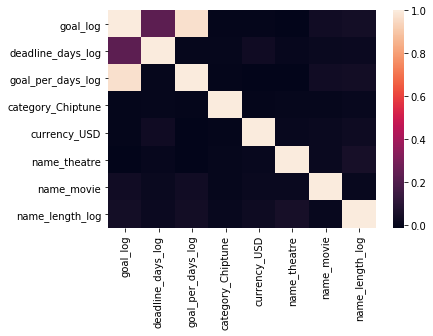

In [15]:
# 相関係数をヒートマップにして可視化
import seaborn as sns
sns.heatmap(df[["goal_log", "deadline_days_log","goal_per_days_log", "category_Chiptune", "currency_USD","name_theatre","name_movie","name_length_log"]].corr())
plt.show()

goalとgoal_per_daysに強い正の相関、どちらか一方のみを使うことが推奨される<br>
country_USとcurrency_USDはほぼ同じ特徴量を持った列であり、どちらか一方でよい<br>
その他はどの説明変数に関してもほぼ相関がない、つまりここで出た7つのうちいずれか5つの説明変数に関しては独立して扱える<br>

In [16]:
#goal_per_daysの値を標準化
df["goal_per_days_standardized"] = (df["goal_per_days"] - df["goal_per_days"].mean()) / df["goal_per_days"].std(ddof=0)

In [17]:
#deadline_daysの値を標準化
df["deadline_days_standardized"] = (df["deadline_days"] - df["deadline_days"].mean()) / df["deadline_days"].std(ddof=0)

In [18]:
#name_lengthの値を正規化
df["name_length_normalized"] = (df["name_length"] - df["name_length"].min()) / (df["name_length"].max() - df["name_length"].min())

<h2>分類アルゴリズムに使う説明変数を決定する</h2>

In [36]:
y = df["state"].values
X = df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].values

In [37]:
#テストデータの分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)

clf.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
w7 = clf.coef_[0, 6]
w8 = clf.coef_[0, 7]
w9 = clf.coef_[0, 8]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}".format(w0, w1, w2, w3, w4, w5, w6, w7, w8))

w0 = -1.614, w1 = -27.097, w2 = -1.428, w3 = 0.823, w4 = 1.215, w5 = 1.353, w6 = 0.044, w7 = 0.811, w8 = 0.368


In [40]:
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

# ラベルを予測
y_est = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))


# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -12.029
正答率 = 65.171%
適合率（Precision） = 65.817%
再現率（Recall） = 95.185%
F1値（F1-score） = 77.822%


In [41]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

,予測 = fail,予測 = successful
正解 = fail,45472,2300
正解 = successful,23617,3024


In [42]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

#ハイパーパラメータ調整
clf_rf = RandomForestClassifier(n_estimators=10,
                             max_depth=9,
                             criterion="gini",
                             min_samples_leaf=2, 
                             min_samples_split=2,
                             random_state=1234)

clf_rf.fit(X_train, y_train)

#テストデータに対する予測データ作成
y_predict = clf_rf.predict(X_test)

In [43]:
#正解率
print(accuracy_score(y_test, y_predict))

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_predict)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_predict)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predict), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

0.6613898109201349
対数尤度 = -11.695
正答率 = 66.139%
適合率（Precision） = 65.817%
再現率（Recall） = 95.185%
F1値（F1-score） = 77.822%


,予測 = fail,予測 = successful
正解 = fail,44301,3471
正解 = successful,21726,4915


1   goal_per_days_standardized   0.5493271938780224
2   deadline_days_standardized   0.32049199046679167
3   name_length_normalized   0.06518252174161294
4   currency_USD   0.041258773983556055
5   name_theatre   0.00934692808895553
6   category_Anthologies   0.007923900072198307
7   name_first   0.0042799933318004016
8   name_movie   0.0012059044010463145
9   category_Chiptune   0.0005870728344701088
10   name_quick   0.00039572120154636936


/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


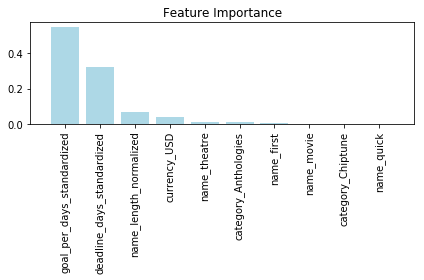

In [44]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
#特徴量の重要度
feature = clf_rf.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.ix[:, 'number']

#特徴量の名前
label = df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print (str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

goal_per_days,deadline_daysが重要だと評価されている

In [45]:
#アダブースト
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf_ad = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                min_samples_leaf=2,
                                                min_samples_split=2, 
                                                random_state=1234,
                                                criterion="gini"))
clf_ad.fit(X_train, y_train)

#テストデータに対する予測データ作成
y_predict = clf_ad.predict(X_test)

In [46]:
#正解率
print(accuracy_score(y_test, y_predict))

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_predict)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_predict)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predict), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

0.6697888809750985
対数尤度 = -11.405
正答率 = 66.979%
適合率（Precision） = 65.817%
再現率（Recall） = 95.185%
F1値（F1-score） = 77.822%


,予測 = fail,予測 = successful
正解 = fail,41861,5911
正解 = successful,18661,7980


[0.45446725 0.28406831 0.19286995 0.00694734 0.00494033 0.00595559
 0.00850881 0.02598685 0.00720664 0.00904893]


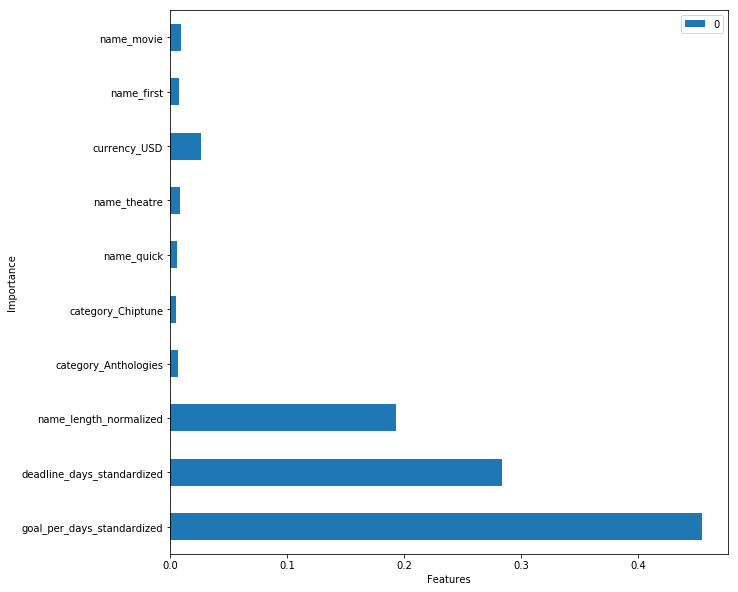

In [47]:
print(clf_ad.feature_importances_)

feature_name=df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].columns[0:]
feature_name

# 説明変数の重要度を棒グラフに出力する。
pd.DataFrame(clf_ad.feature_importances_, feature_name).plot.barh(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [30]:
y = df["state"].values
X = df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie", \
       "category_Residencies","category_Dance","category_Letterpress","category_Literary Spaces","category_Indie Rock"]].values

In [31]:
#テストデータの分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
#アダブースト
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV

clf_ad = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                min_samples_leaf=2,
                                                min_samples_split=2, 
                                                random_state=1234,
                                                criterion="gini"))

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(clf_ad, cv=10, scoring='accuracy')

rfecv.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
pd.to_pickle(rfecv,'../1_data/rfecv.model')

In [ ]:
#テストデータに対する予測データ作成
y_predict = rfecv.predict(X_test)

In [ ]:
#正解率
print(accuracy_score(y_test, y_predict))

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_predict)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_predict)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predict), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

In [ ]:
print(clf_ad.feature_importances_)

feature_name=df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].columns[0:]
feature_name

# 説明変数の重要度を棒グラフに出力する。
pd.DataFrame(clf_ad.feature_importances_, feature_name).plot.barh(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [48]:
#XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# xgboostモデルの作成
clf_xgb = xgb.XGBClassifier()

# ハイパーパラメータ探索
clf_xgn = GridSearchCV(clf_xgb, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
clf_xgn.fit(X_train, y_train)
print (clf_xgn.best_params_, clf_xgn.best_score_)

# 改めて最適パラメータで学習
clf_xgb = xgb.XGBClassifier(**clf_xgn.best_params_)
clf_xgb.fit(X_train, y_train)

# 学習モデルの保存、読み込み
import pickle
pickle.dump(clf_xgb, open("model_xgb.pkl", "wb"))
clf_xgb = pickle.load(open("model_xgb.pkl", "rb"))

# 学習モデルの評価
pred = clf_xgb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.2min finished


{'max_depth': 4, 'n_estimators': 200} 0.6679007824652528
[[42091  5681]
 [18896  7745]]
              precision    recall  f1-score   support

           0       0.69      0.88      0.77     47772
           1       0.58      0.29      0.39     26641

   micro avg       0.67      0.67      0.67     74413
   macro avg       0.63      0.59      0.58     74413
weighted avg       0.65      0.67      0.64     74413



In [53]:
#正解率
print(accuracy_score(y_test, pred))

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predict), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

0.6697216884146587
対数尤度 = -11.407
正答率 = 66.972%
適合率（Precision） = 69.016%
再現率（Recall） = 88.108%
F1値（F1-score） = 77.402%


,予測 = fail,予測 = successful
正解 = fail,41861,5911
正解 = successful,18661,7980


[0.26121548 0.22872452 0.05306933 0.09397195 0.01367055 0.00888934
 0.08504287 0.19462478 0.04583235 0.01495881]


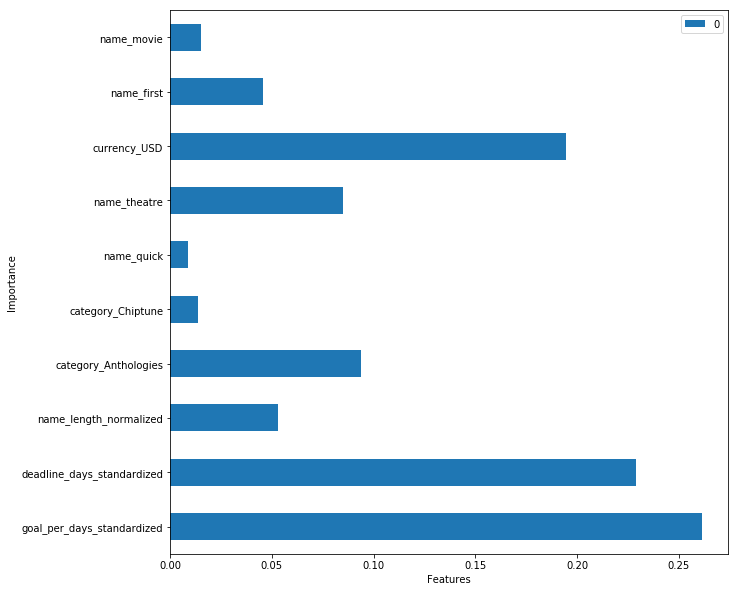

In [54]:
print(clf_xgb.feature_importances_)

feature_name=df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].columns[0:]
feature_name

# 説明変数の重要度を棒グラフに出力する。
pd.DataFrame(clf_xgb.feature_importances_, feature_name).plot.barh(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [63]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 3,
        'learning_rate': 0.1,
        'num_leaves': 23,
        'min_data_in_leaf': 1,
        'num_iteration': 200,
        'verbose': 0
}

# train
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=50,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.64447
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.638127
[3]	valid_0's multi_logloss: 0.632941
[4]	valid_0's multi_logloss: 0.62849
[5]	valid_0's multi_logloss: 0.62473
[6]	valid_0's multi_logloss: 0.621623
[7]	valid_0's multi_logloss: 0.619035
[8]	valid_0's multi_logloss: 0.616619
[9]	valid_0's multi_logloss: 0.61465
[10]	valid_0's multi_logloss: 0.61299
[11]	valid_0's multi_logloss: 0.611464
[12]	valid_0's multi_logloss: 0.610135
[13]	valid_0's multi_logloss: 0.609033
[14]	valid_0's multi_logloss: 0.608047
[15]	valid_0's multi_logloss: 0.607182
[16]	valid_0's multi_logloss: 0.606423
[17]	valid_0's multi_logloss: 0.605689
[18]	valid_0's multi_logloss: 0.605032
[19]	valid_0's multi_logloss: 0.60452
[20]	valid_0's multi_logloss: 0.604046
[21]	valid_0's multi_logloss: 0.603591
[22]	valid_0's multi_logloss: 0.603172
[23]	valid_0's multi_logloss: 0.60283
[24]	valid_0's multi_logloss: 0.602456
[25]	valid_0's mult

In [64]:
#正解率
print(accuracy_score(y_test, y_pred))

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predict), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

0.6700576512168572
対数尤度 = -11.396
正答率 = 67.006%
適合率（Precision） = 69.306%
再現率（Recall） = 87.246%
F1値（F1-score） = 77.248%


,予測 = fail,予測 = successful
正解 = fail,41861,5911
正解 = successful,18661,7980
